In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.misc import derivative
import math as m
from scipy.optimize import minimize

In [2]:
def error_function(arrymena, arrystd, dfsum):
    return np.random.normal(loc=arrymena, scale=arrystd, size=dfsum)

def get_OCV_data(file_name, dataframes=None):
    """
    Retrieves and processes OCV data. If a file path is provided, it reads the .xlsx file. 
    If a preloaded dataframe dictionary is provided, it retrieves the relevant data.
    """
    # Check if file_name is a path or a key in dataframes
    if dataframes is None or file_name not in dataframes:
        # Load the data from an .xlsx file if dataframes dictionary is not provided or file_name is a path
        ocv_df = pd.read_excel(file_name)
    else:
        # Otherwise, retrieve the DataFrame from the provided dataframes dictionary
        ocv_df = dataframes[file_name]
    
    # Process OCV data as before
    ocv_df_cleaned = ocv_df.iloc[1:].reset_index(drop=True)
    
    # Extract charging and discharging data, skipping the first row
    charging_data = ocv_df_cleaned.iloc[:, [1, 2]].dropna().reset_index(drop=True)
    discharging_data = ocv_df_cleaned.iloc[:, [4, 5]].dropna().reset_index(drop=True)

    # Rename columns for clarity
    charging_data.columns = ['data_SOC', 'data_U']
    discharging_data.columns = ['data_SOC', 'data_U']

    # Create the structured dictionary with processed data
    data_OCV = {
        'charge': {
            'SOC': np.array(charging_data['data_SOC']).astype(np.float64),
            'U': np.array(charging_data['data_U']).astype(np.float64)
        },
        'discharge': {
            'SOC': np.array(discharging_data['data_SOC']).astype(np.float64),
            'U': np.array(discharging_data['data_U']).astype(np.float64)
        }
    }
    
    return data_OCV

def get_data(file_name):
    hppc_df = pd.read_excel(file_name)
    print(file_name)
    # Clean and format the HPPC data
    hppc_df_cleaned = hppc_df.iloc[3:].reset_index(drop=True)
    try:
        hppc_df_cleaned.columns = ['Step', 'Voltage(V)', 'Current_inv(A)', 'SOC_true(%)', 'SOC_Calc', 'Error', 'Temp', 'Comment']
    except:
        hppc_df_cleaned.columns = ['Step', 'Voltage(V)', 'Current_inv(A)', 'SOC_true(%)', 'SOC_Calc', 'Error', 'Temp', 'AS', 'Current', 'Comment']
    
    data = {
        'Voltage': np.array(hppc_df_cleaned['Voltage(V)'].values, dtype=float),
        'Current': np.array(hppc_df_cleaned['Current_inv(A)'].values, dtype=float),
        'SOC': np.array(hppc_df_cleaned['SOC_true(%)'].values, dtype=float)
    }
    return data

def soc_to_voltage(data_OCV):
    """
    Defines the interpolated U_ocp(SoC) functions for charging and discharging process
    """
    # Interpolation functions for charge and discharge using OCV data and also inverted ones
    interp_func_charge = interp1d(data_OCV['charge']['SOC'], data_OCV['charge']['U'], 
                                    bounds_error=False, fill_value="extrapolate")
    interp_func_discharge = interp1d(data_OCV['discharge']['SOC'], data_OCV['discharge']['U'], 
                                        bounds_error=False, fill_value="extrapolate")

    return interp_func_charge, interp_func_discharge

data_OCV = get_OCV_data("Cha_Dis_OCV_SOC_Data.xlsx")
ocp_charge_fn, ocp_discharge_fn = soc_to_voltage(data_OCV)

def ocp_charge_derivative(soc):
    return derivative(ocp_charge_fn, soc, dx=1e-6)  # Numerical derivative

def ocp_discharge_derivative(soc):
    return derivative(ocp_discharge_fn, soc, dx=1e-6)  # Numerical derivative

def get_data_Phase_2(file_name):
    hppc_df = pd.read_excel(file_name)
    print(file_name)
    # Clean and format the HPPC data
    hppc_df_cleaned = hppc_df.iloc[6:].reset_index(drop=True)
    try:
        hppc_df_cleaned.columns = ['Step', 'Voltage(V)', 'Current_inv(A)', 'SOC_true(%)', 'SOC_Calc', 'Error', 'Temp1', 'Temp2', 'Temp3', 'Temp4', 'AS', 'Current', 'Comment']
    except:
        hppc_df_cleaned.columns = ['Step', 'Voltage(V)', 'Current_inv(A)', 'SOC_true(%)', 'SOC_Calc', 'Error', 'Temp', 'AS', 'Current', 'Comment']
    sumcount = hppc_df_cleaned.shape[0]
    data = {
        'Voltage': np.array(hppc_df_cleaned['Voltage(V)'].values, dtype=float) + error_function(2, 1, sumcount),
        'Current': np.array(hppc_df_cleaned['Current_inv(A)'].values, dtype=float) + error_function(3 * 0.001, 1 * 0.001, sumcount),
        'SOC': np.array(hppc_df_cleaned['SOC_true(%)'].values, dtype=float)
    }
    return data


In [3]:
#Q_tot = 9.906577834413936e-05**(-1)

In [4]:
class KalmanFilter(object):
    def __init__(self, x, R0, F, B, P, Q, R, Hx_charge, Hx_discharge, HJacobian_charge, HJacobian_discharge):
        self._x = x
        self._R0 = R0
        self._F = F
        self._B = B
        self._P = P
        self._Q = Q
        self._R = R
        self._Hx_charge = Hx_charge
        self._Hx_discharge = Hx_discharge
        self._HJacobian_charge = HJacobian_charge
        self._HJacobian_discharge = HJacobian_discharge
        self.mode = "charge"  # Default mode is charging

    def set_mode_from_current(self, current):
        """
        Set the mode ('charge' or 'discharge') based on the current value.
        Positive current is charge, negative is discharge.
        """
        if current >= 0:
            self.mode = "charge"
        elif current < 0:
            self.mode = "discharge"
        else:
            self.mode = None  # Undefined for zero current, but you can handle it as needed


    def update(self, z, u=0):
        # Dynamically set mode based on the current sign
        self.set_mode_from_current(u)
        P = self._P
        R = self._R
        x = self._x
        z = z - self._R0 * u

        if self.mode == "charge":
            H = self._HJacobian_charge(x)
            hx = self._Hx_charge(x)
        elif self.mode == "discharge":
            H = self._HJacobian_discharge(x)
            hx = self._Hx_discharge(x)

        S = H * P * H.T + R
        K = P * H.T * S.I
        self._K = K

        y = np.subtract(z, hx)
        self._x = x + K * y

        KH = K * H
        I_KH = np.identity((KH).shape[1]) - KH
        self._P = I_KH * P #* I_KH.T + K * R * K.T # maybe not correct. should be I_KH * P

    def predict(self, u=0):
        self._x = self._F * self._x + self._B * u
        self._P = self._F * self._P * self._F.T + self._Q

    @property
    def x(self):
        return self._x


def get_EKF(Q_tot, R0, R1, R1C1, R2, R2C2, std_dev, time_step):
    # initial state (SoC is intentionally set to a wrong value)
    # x = [[SoC], [RC voltage]]
    x = np.matrix([ [50.0],\
                    [0.0],\
                    [0.0]]
                    )

    exp_coeff1 = m.exp(-time_step / R1C1)
    exp_coeff2 = m.exp(-time_step / R2C2)
    # state transition model
    F = np.matrix([ [1, 0, 0         ],\
                    [0, exp_coeff1, 0],\
                    [0, 0, exp_coeff2]])

    # control-input model
    B = np.matrix([ [time_step / (Q_tot)],\
                    [ R1 * (1 - exp_coeff1)],\
                    [ R2 * (1 - exp_coeff2)]])

    # variance from std_dev
    var = std_dev ** 2

    # measurement noise
    R = var

    # state covariance
    P = np.matrix([ [var, 0, 0],\
                    [0, var, 0],\
                    [0, 0, var]])

    # process noise covariance matrix
    Q = np.matrix([ [var / 50, 0, 0],\
                    [0, var / 50, 0],\
                    [0, 0, var / 50]])
    
    # Jacobian and Hx for charge
    def HJacobian_charge(x):
        return np.matrix([[ocp_charge_derivative(x[0, 0])*100, 1, 1]])

    def Hx_charge(x):
        return ocp_charge_fn(x[0, 0]) + x[1, 0] + x[2, 0]

    # Jacobian and Hx for discharge
    def HJacobian_discharge(x):
        return np.matrix([[ocp_discharge_derivative(x[0, 0])*100, 1, 1]])

    def Hx_discharge(x):
        return ocp_discharge_fn(x[0, 0]) + x[1, 0] + x[2, 0]

    return KalmanFilter(x, R0, F, B, P, Q, R, Hx_charge, Hx_discharge, HJacobian_charge, HJacobian_discharge)

In [5]:
plt.figure(figsize=(10, 6))
def run_kalman_filter(Q_tot, R0, R1, R1C1, R2, R2C2, std_dev,time_step, dataset, plot=False):
    # initialization process for first 100 points
    start_point = 100
    """
    Run the Kalman filter on given data and calculate RMSE.

    Args:
        R0, R1, C1 (float): Battery parameters.
        std_dev (float): Standard deviation for measurement noise.
        time_step (float): Time step for the simulation.
        data (dict): Dictionary containing 'Voltage', 'Current', and 'SOC' arrays.

    Returns:
        float: RMSE of estimated SoC compared to true SoC.
    """
    rmse = 0
    for data in dataset:
        # Extract data
        voltage_data = data['Voltage']
        current_data = data['Current']
        soc_true = data['SOC']
        time_steps = len(current_data)

        # Initialize Kalman filter
        kf = get_EKF(Q_tot, R0, R1, R1C1, R2, R2C2, std_dev, time_step)
        z_measured = voltage_data  # Use measured voltage directly from data
        estimated_soc = np.zeros(time_steps)

        # Simulate and run Kalman filter
        for t in range(time_steps):
            # if t % 10000 == 0:
            #     print(f"{t} operations of {time_steps}")
            current = current_data[t]
            kf.set_mode_from_current(current)
            
            # Kalman Filter steps
            kf.predict(u=current)  # Predict next state
            kf.update(z_measured[t], u=current)  # Update state with measurement
            
            # Store estimated SoC
            estimated_soc[t] = kf.x[0, 0]
    
        # Calculate RMSE
        new_rmse = np.sqrt(np.mean((estimated_soc[start_point:] - soc_true[start_point:]) ** 2)) 
        rmse = rmse + new_rmse
        print(f"RMSE: {new_rmse:.4f}") 
        if plot:
            plt.plot(range(time_steps), soc_true, label="True SoC", color='blue', linewidth=2)
            plt.plot(range(time_steps), estimated_soc, label="Estimated SoC", color='orange', linestyle='--', linewidth=2)
            plt.xlabel("Time Steps")
            plt.ylabel("State of Charge (SoC)")
            plt.title("True SoC vs Estimated SoC")
            plt.legend()
            plt.grid(True)
            plt.show()
    rmse = rmse/len(dataset)    
    print(f"average RMSE: {rmse:.4f}")
    print(Q_tot,R0,R1,R1C1, R2,R2C2,std_dev)
    # Plotting true SoC vs estimated SoC


    return rmse

<Figure size 1000x600 with 0 Axes>

In [6]:
from skopt.space import Real
bounds = [
    Real(9500, 50000, name="Q_tot"),     # R0 bounds
    Real(5e-6, 1e-3, name="R0"),     # R0 bounds
    Real(5e-8, 1e-4, name="R1"),     # R1 bounds
    Real(1e-12, 1e-7, name="R1C1"),     # C1 bounds
    Real(1e-10, 1e-5, name="std_dev") # std_dev bounds
]

In [7]:
Q_tot = 10094
std_dev =  1e-10

In [8]:
from scipy.optimize import minimize
import numpy as np

def objective(dataset, R0, R1, R1C1, R2, R2C2, Q_tot=Q_tot, std_dev=std_dev):
    """
    Objective function to minimize RMSE by varying parameters.

    Args:
        R0, R1, R1C1, R2, R2C2 (float): Parameters of the Kalman filter.
        dataset (dict): Dictionary containing 'Voltage', 'Current', and 'SOC' arrays.

    Returns:
        float: RMSE from the Kalman filter with the given parameters.
    """
    time_step = 1  # Fixed time_step for the Kalman filter
    
    # Call the Kalman filter
    return run_kalman_filter(Q_tot, R0, R1, R1C1, R2, R2C2, std_dev, time_step, dataset)

def optimize_rmse_nelder_mead(dataset):
    """
    Optimize the Kalman filter parameters to minimize RMSE using Nelder-Mead.

    Args:
        dataset (dict): Dictionary containing 'Voltage', 'Current', and 'SOC' arrays.

    Returns:
        dict: Dictionary containing optimized parameters and the minimized RMSE.
    """
    # Initial guesses for log10-scaled parameters
    initial_guess = [-3, -4, 1, -5, 2]  # Corresponds to log10(R0), log10(R1), log10(R1C1), log10(R2), log10(R2C2)

    def wrapped_objective(params):
        """
        Wrapper function for Nelder-Mead to evaluate the objective.

        Args:
            params (list): Logarithmic parameters for optimization.

        Returns:
            float: RMSE for the given parameters.
        """
        log_R0, log_R1, log_R1C1, log_R2, log_R2C2 = params

        # Convert log-scale parameters back to linear scale
        R0 = 10.0 ** log_R0
        R1 = 10.0 ** log_R1
        R2 = 10.0 ** log_R2
        R1C1 = 10.0 ** log_R1C1
        R2C2 = 10.0 ** log_R2C2 * 3

        return objective(dataset, R0, R1, R1C1, R2, R2C2)

    # Perform Nelder-Mead optimization
    result = minimize(
        fun=wrapped_objective,
        x0=initial_guess,
        method='Nelder-Mead',
        options={'maxiter': 160, 'disp': True}
    )

    # Prepare the result dictionary
    optimized_params = result.x
    return {
        "Optimized Parameters": {
            "R0": 10.0 ** optimized_params[0],
            "R1": 10.0 ** optimized_params[1],
            "R1C1": 10.0 ** optimized_params[2],
            "R2": 10.0 ** optimized_params[3],
            "R2C2": 10.0 ** optimized_params[4] * 3,
        },
        "Fixed Parameters": {
            "Q_tot": Q_tot,
            "std_dev": std_dev,
        },
        "Result": {
            "RMSE": result.fun,
        },
        "Convergence": {
            "Message": result.message,
            "Success": result.success,
        }
    }



In [9]:

import os

# Directories to search for .xlsx files
directories = ['./data/', './Phase_2_data/']

# Collect all .xlsx files from both directories
xlsx_files = []
for directory in directories:
    xlsx_files.extend(
        [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.xlsx')]
    )

# Print the collected files
len(xlsx_files)

16

In [10]:
class MultiFileDataset():
    def __init__(self, file_keys):
        """
        Dataset that uses preloaded DataFrames to extract sequences.
        Args:
            file_keys (list): List of keys to retrieve the DataFrames from the dictionary.
            dataframes (dict): Dictionary of DataFrames containing the data.
            seq_length (int): Length of the input sequence (number of time steps used for prediction).
            data_OCV (dict): Dictionary containing charge and discharge SOC-U data from OCV for interpolation.
        """
        self.file_keys = file_keys
        self.data_sequences = []  # List to store sequences

        # Load all data into memory and create sequences
        self.load_all_sequences()

    def load_all_sequences(self):
        """
        Loads all data from DataFrames and stores it as a list of sequences.
        """
        for file_key in self.file_keys:
            # Check if "Phase_2" is in the file_key
            if "Phase_2" in file_key:
                # Call get_data_Phase_2 if it contains "Phase_2"
                data_HPPC = get_data_Phase_2(file_key)
            else:
                # Otherwise, call get_data
                data_HPPC = get_data(file_key)
            # Loop through the data to create sequences
            self.data_sequences.append(data_HPPC)

    def __len__(self):
        """
        Returns the total number of sequences across all files.
        """
        return len(self.data_sequences)

    def __getitem__(self, idx):
        """
        Retrieves a sequence by index.
        """
        return self.data_sequences[idx]
    
dataset = MultiFileDataset(xlsx_files[:5])

./data/GenerateTestData_S1_DAY4to7.xlsx
./data/GenerateTestData_S1_DAY0to4.xlsx
./data/GenerateTestData_S2_DAY4to7.xlsx
./data/GenerateTestData_S2_DAY0to4.xlsx
./data/GenerateTestData_S3_DAY4to7.xlsx


Goal: RMSE < 4.5 

RMSE_min ~ 2.9



In [11]:
# Initial guesses for the parameters
# initial_params = [1e-4, 1e-4, 1e-4, 1e-4]  # [R0, R1, C1, std_dev, time_step]

# Optimize
optimization_result = optimize_rmse_nelder_mead(dataset)

# Print the result
print("Optimized Parameters:")
for key, value in optimization_result["Optimized Parameters"].items():
    print(f"{key}: {value:.6f}")
print(f"Minimized RMSE: {optimization_result["Result"]['RMSE']:.6f}")

C:\Users\nemtu\AppData\Local\Temp\ipykernel_12756\1440133515.py:75: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(ocp_charge_fn, soc, dx=1e-6)  # Numerical derivative
C:\Users\nemtu\AppData\Local\Temp\ipykernel_12756\1440133515.py:78: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(ocp_discharge_fn, soc, dx=1e-6)  # Numerical derivative


RMSE: 5.4896
RMSE: 4.1480
RMSE: 7.0102
RMSE: 5.5382
RMSE: 0.6090
average RMSE: 4.5590
10094 0.001 0.0001 10.0 1e-05 300.0 1e-10
RMSE: 5.5157
RMSE: 4.0311
RMSE: 6.9815
RMSE: 5.5553
RMSE: 0.5328
average RMSE: 4.5233
10094 0.0007079457843841374 0.0001 10.0 1e-05 300.0 1e-10
RMSE: 5.4952
RMSE: 4.1206
RMSE: 7.0097
RMSE: 5.5527
RMSE: 0.5967
average RMSE: 4.5550
10094 0.001 6.309573444801929e-05 10.0 1e-05 300.0 1e-10
RMSE: 5.4848
RMSE: 4.1432
RMSE: 7.0061
RMSE: 5.5429
RMSE: 0.6078
average RMSE: 4.5570
10094 0.001 0.0001 11.220184543019636 1e-05 300.0 1e-10
RMSE: 5.4899
RMSE: 4.1454
RMSE: 7.0103
RMSE: 5.5395
RMSE: 0.6084
average RMSE: 4.5587
10094 0.001 0.0001 10.0 5.623413251903491e-06 300.0 1e-10
RMSE: 5.1936
RMSE: 5.1901
RMSE: 8.5470
RMSE: 5.5306
RMSE: 0.6493
average RMSE: 5.0221
10094 0.001 0.0001 10.0 1e-05 377.67762353825026 1e-10
RMSE: 5.6088
RMSE: 3.6634
RMSE: 6.0774
RMSE: 6.3884
RMSE: 0.6076
average RMSE: 4.4691
10094 0.0008709635899560796 8.317637711026709e-05 10.471285480508996 7.9

average RMSE: 3.5387

10094 7.422984456191953e-05 0.0011639937387559955 82.81129166783788 10.0

C:\Users\nemtu\AppData\Local\Temp\ipykernel_12756\1440133515.py:75: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(ocp_charge_fn, soc, dx=1e-6)  # Numerical derivative
C:\Users\nemtu\AppData\Local\Temp\ipykernel_12756\1440133515.py:78: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(ocp_discharge_fn, soc, dx=1e-6)  # Numerical derivative


RMSE: 5.3624


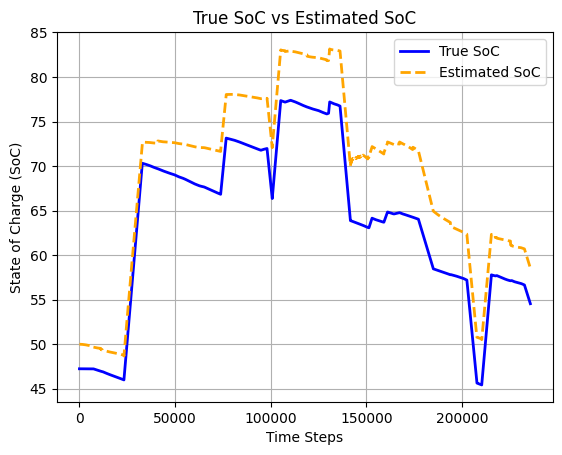

RMSE: 3.6800


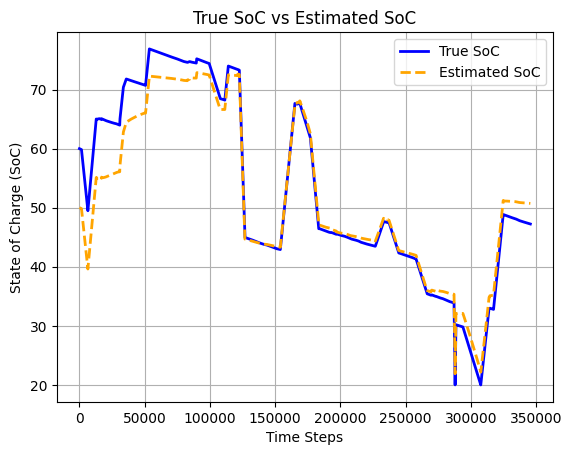

RMSE: 6.2596


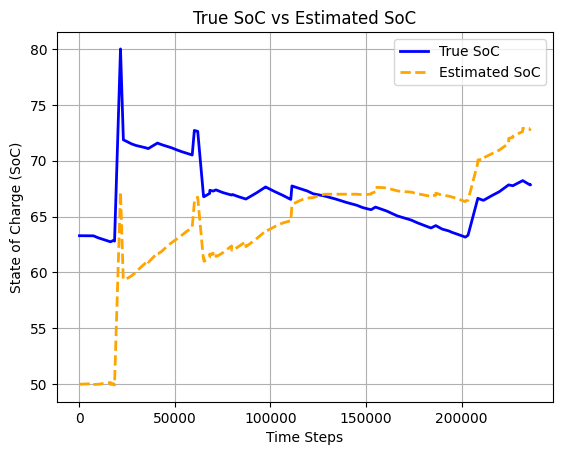

RMSE: 5.8369


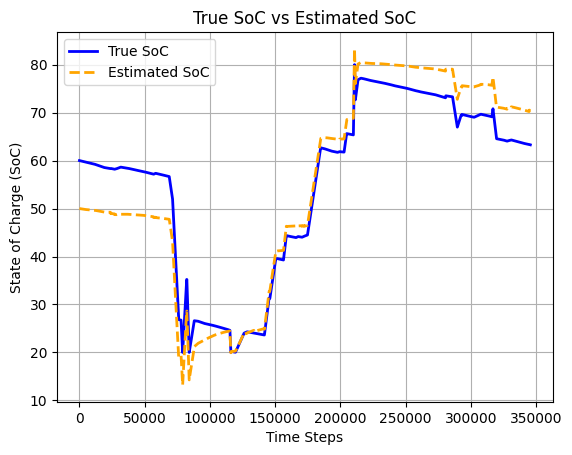

RMSE: 0.6214


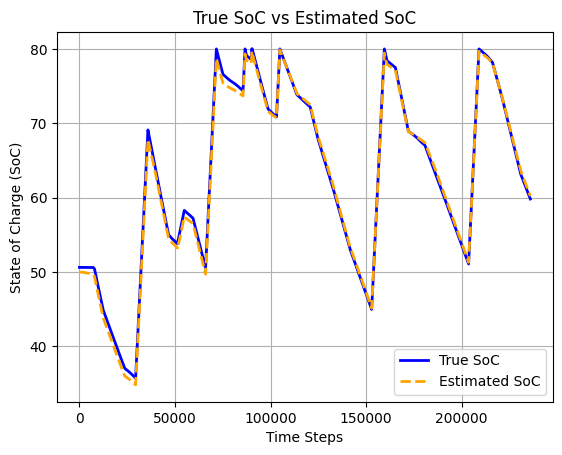

average RMSE: 4.3521
10094 0.00011947706808024891 2.8553889454992134e-05 13.726616124384334 0.0009626954846986228 248.27623002011936 1e-10


4.352058666288359

In [12]:
time_step = 1
#optimization_result["Optimized Parameters"]["R0"]
run_kalman_filter(optimization_result["Fixed Parameters"]["Q_tot"], 
                  optimization_result["Optimized Parameters"]["R0"], 
                  optimization_result["Optimized Parameters"]["R1"],
                  optimization_result["Optimized Parameters"]["R1C1"], 
                  optimization_result["Optimized Parameters"]["R2"],
                  optimization_result["Optimized Parameters"]["R2C2"],                   
                  optimization_result["Fixed Parameters"]["std_dev"],
                  time_step ,dataset, plot=True)

In [13]:
# Function to save the optimization result as a text file
def save_as_text_file(data, file_name):
    file_content = ""
    for section, parameters in data.items():
        file_content += f"{section}:\n"
        for key, value in parameters.items():
            file_content += f"  {key}: {value}\n"
            print(value)
            file_content += "\n"
    
    # Write to the file
    with open(file_name, "w") as file:
        file.write(file_content)
    print(f"File saved as {file_name}")

# Save the result to a text file
save_as_text_file(optimization_result, "optimization_result2.txt")

0.00011947706808024891
2.8553889454992134e-05
13.726616124384334
0.0009626954846986228
248.27623002011936
10094
1e-10
4.352058666288359
Optimization terminated successfully.
True


OSError: [Errno 22] Invalid argument: 'optimization_result2.txt'